In this notebook we consider the K2 target

- We correct for K2 motion
- We do BLS fitting
- We attempt to find planet periods

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
import lightkurve as lk
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table
from lightkurve import search_lightcurvefile
from lightkurve import search_lightcurve
from lightkurve import search_targetpixelfile
import exoplanet as xo

In [2]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 18
rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True
plt.rcParams['axes.linewidth']=1.5

# Kepler Data

https://exoplanetarchive.ipac.caltech.edu/overview/EPIC%20246711015

In [3]:
star = lk.search_lightcurve('EPIC 246711015',author='EVEREST')
#lk

In [4]:
k2 = star.download_all()

In [5]:
k2

LightCurveCollection of 1 objects:
    0: <KeplerLightCurve LABEL="EPIC 246711015" CAMPAIGN=13 AUTHOR=EVEREST FLUX_ORIGIN=flux>

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

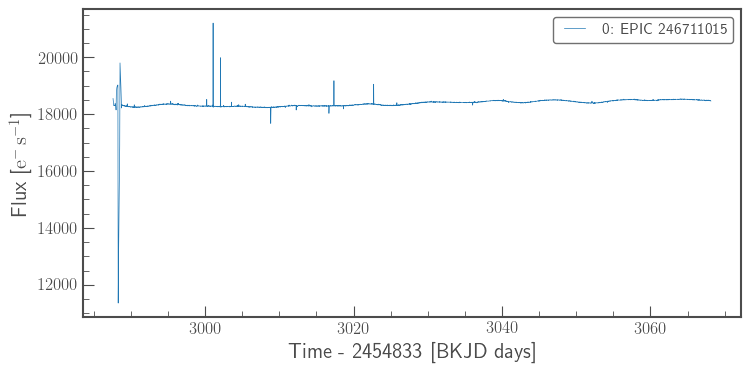

In [6]:
k2.plot()

In [7]:
k2[0]['flux'].value

array([18547.63448381, 18497.23201215, 18413.56787959, ...,
       18479.46277516, 18476.39518636, 18459.18779199])

In [8]:
#k2 = pd.read_csv('/Users/lupitatovar/Cool-Worlds/k2.csv',delim_whitespace=True,names=['Time','PDCSAP_Flux'])
#k2

In [9]:
k2_time = k2[0]['time'].value
k2_flux = k2[0]['flux'].value

In [10]:
lcmedian = (k2_flux/np.nanmedian(k2_flux))-1
lcmedian

array([0.00958944, 0.00684592, 0.0022919 , ..., 0.0058787 , 0.00571173,
       0.00477509])

Text(0, 0.5, 'Relative Flux')

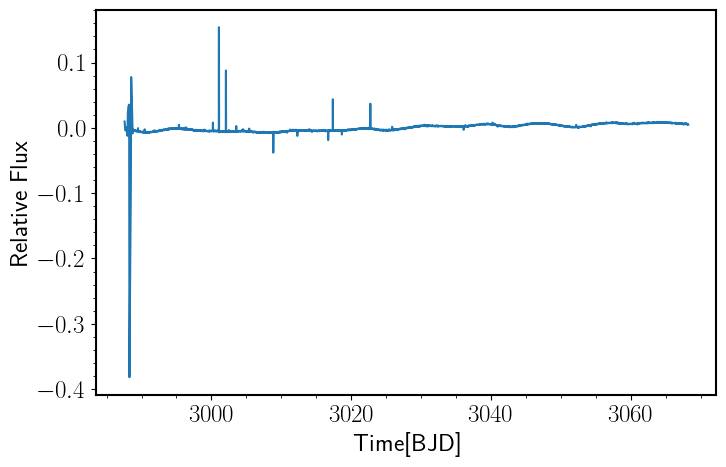

In [98]:
plt.plot(k2_time,lcmedian)
plt.minorticks_on()
plt.xlabel('Time[BJD]')
plt.ylabel('Relative Flux')
#plt.xlim(2987,2992)

(3007.0, 3012.0)

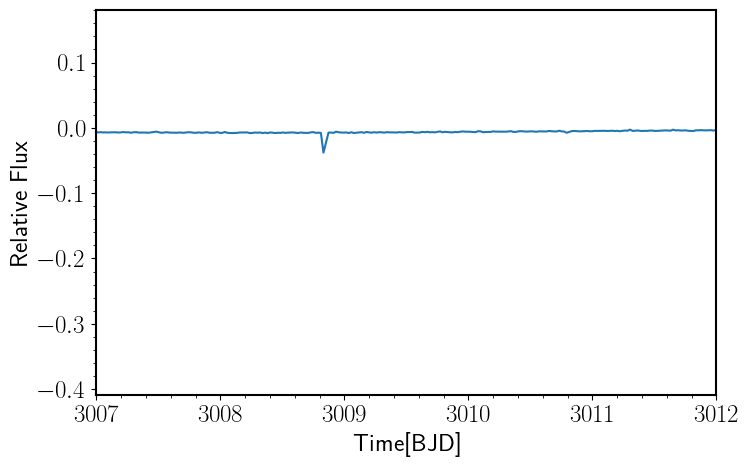

In [16]:
plt.plot(k2_time,lcmedian)
plt.minorticks_on()
plt.xlabel('Time[BJD]')
plt.ylabel('Relative Flux')
plt.xlim(3007,3012)

Downloading the TPF

Following this tutorial:http://docs.lightkurve.org/tutorials/3-science-examples/periodograms-optimizing-the-snr.html

To get rid of some of the K2 motion that is in the data

In [54]:
TARGET = "EPIC 246711015"
tpf = lk.search_targetpixelfile(TARGET, author="K2", cadence='short').download()

In [55]:
tpf

KeplerTargetPixelFile Object (ID: 246711015)

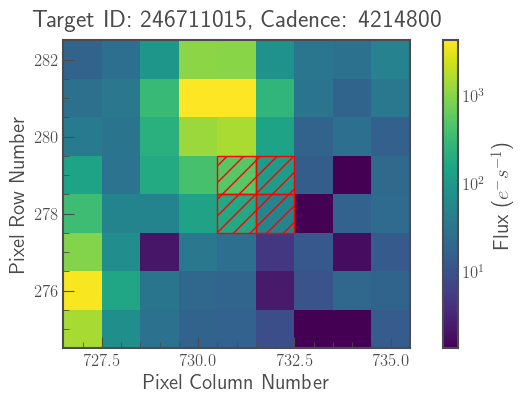

In [56]:
tpf.plot(scale='log', aperture_mask=tpf.pipeline_mask);

In [21]:
lc = tpf.to_lightcurve()
lc = lc.normalize(unit='ppm').remove_nans().remove_outliers().fill_gaps()

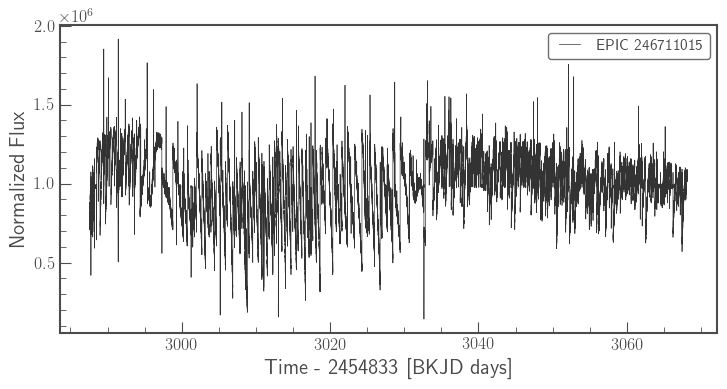

In [22]:
lc.plot();

In [24]:
import astropy.units as u
pg = lc.to_periodogram(freq_unit=u.microHertz, maximum_frequency=400, minimum_frequency=10)

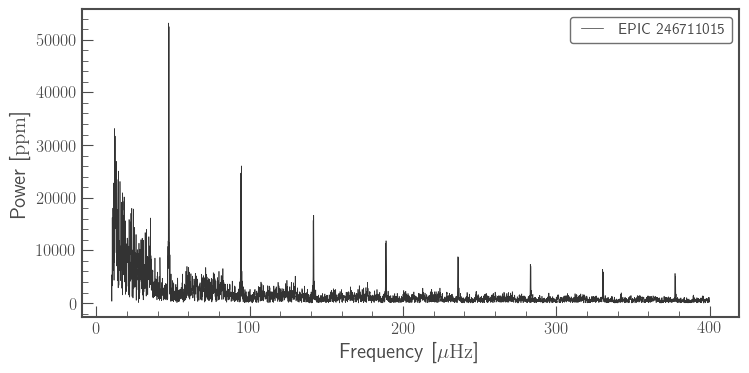

In [25]:
ax = pg.plot();

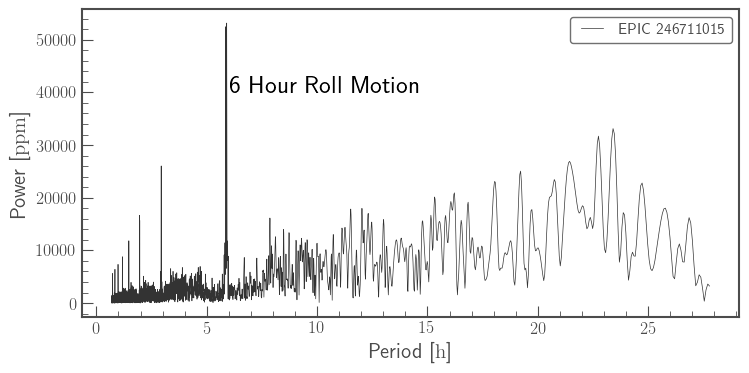

In [28]:
ax = pg.plot(view='Period', unit=u.hour)
ax.text(6, 40000, '6 Hour Roll Motion');

In [29]:
lc = tpf.to_lightcurve().normalize().remove_nans().remove_outliers()
clc = lc.to_corrector("sff").correct(windows=10).remove_outliers().fill_gaps()

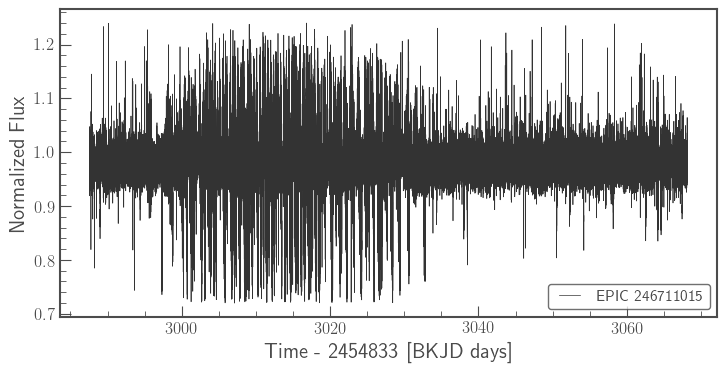

In [30]:
clc.plot();

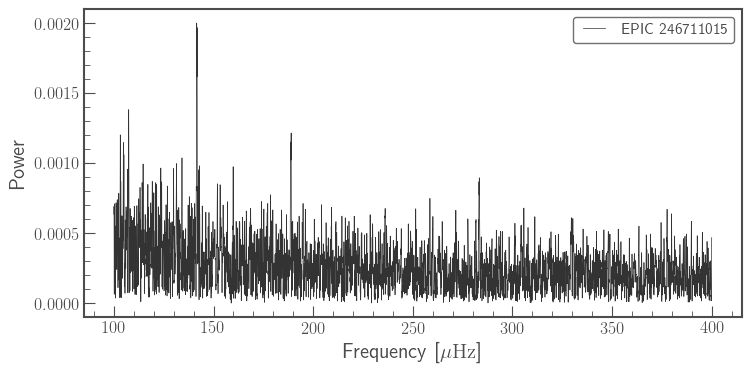

In [31]:
pg_clean = clc.to_periodogram(freq_unit=u.microHertz, maximum_frequency=400, minimum_frequency=100)
ax = pg_clean.plot()

100%|██████████| 3/3 [00:20<00:00,  6.80s/it]


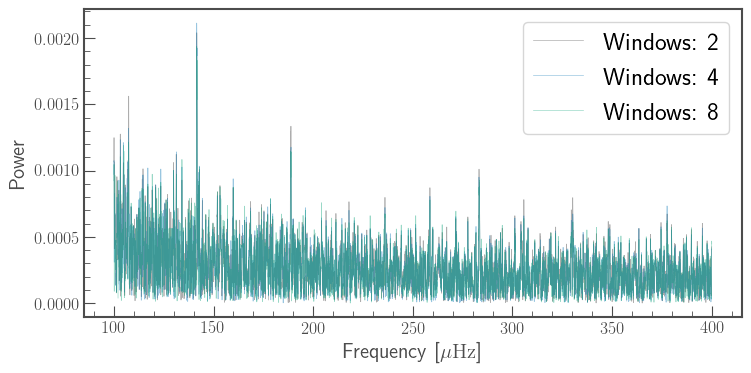

In [32]:
# Loop over several windows
from tqdm import tqdm
for windows in tqdm([2, 4, 8]):
    # Create the light curve
    lc =  tpf.to_lightcurve().normalize().remove_nans().remove_outliers()
    clc = lc.to_corrector('sff').correct(windows=windows).remove_outliers().fill_gaps()
    # Create the periodogram
    p_clean = clc.to_periodogram(freq_unit=u.microHertz, maximum_frequency=400, minimum_frequency=100)
    # Plot the periodogram
    if windows == 2:
        ax = p_clean.plot(alpha=0.4, label='Windows: {}'.format(windows))
    else:
        p_clean.plot(ax=ax, alpha=0.4, label='Windows: {}'.format(windows))
ax.legend();

We can also vary the aperture size

In [34]:
aperture_small = tpf.create_threshold_mask(threshold=50)
aperture_large = tpf.create_threshold_mask(threshold=2)

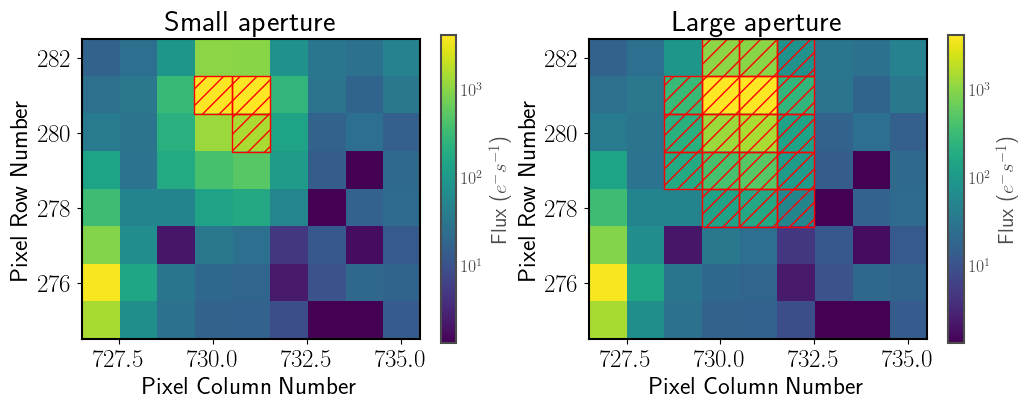

In [35]:
# Two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot pipeline aperture mask
tpf.plot(axs[0], scale='log', aperture_mask=aperture_small)
axs[0].set_title('Small aperture')

# Plot larger aperture mask
tpf.plot(axs[1], scale='log', aperture_mask=aperture_large)
axs[1].set_title('Large aperture');

In [36]:
# Create the light curve with the pipelien aperture.
lc_small = tpf.to_lightcurve(aperture_mask=aperture_small).normalize().remove_nans().remove_outliers()
lc_small = lc_small.to_corrector('sff').correct().remove_outliers().fill_gaps()

# Create a light curve with a slightly larger aperture
lc_large = tpf.to_lightcurve(aperture_mask=aperture_large).normalize().remove_nans().remove_outliers()
lc_large = lc_large.to_corrector('sff').correct().remove_outliers().fill_gaps()

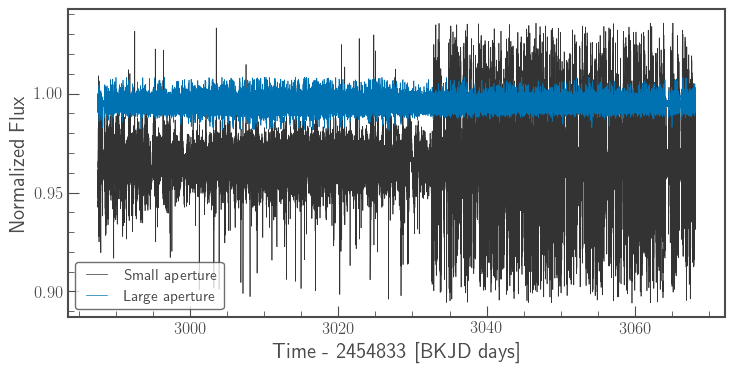

In [37]:
#Plot the pipeline and large aperture light curves
ax = lc_small.plot(label='Small aperture')
lc_large.plot(ax=ax, label='Large aperture');

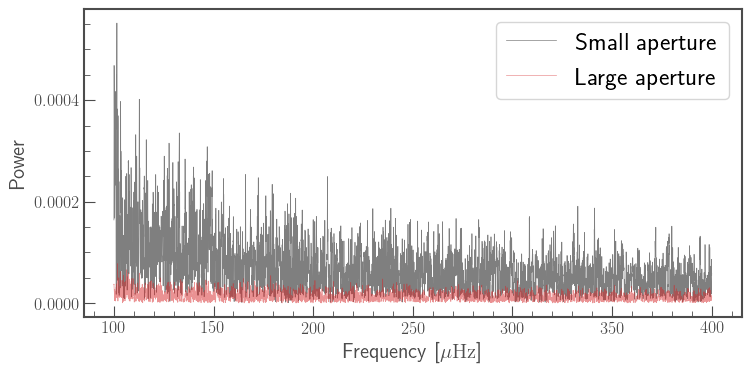

In [38]:
# Create the periodograms
pg_small = lc_small.to_periodogram(freq_unit=u.microHertz, maximum_frequency=400, minimum_frequency=100)
pg_large = lc_large.to_periodogram(freq_unit=u.microHertz, maximum_frequency=400, minimum_frequency=100)


# Plot the periodograms
ax = pg_small.plot(c='k', alpha=0.5, label='Small aperture')
pg_large.plot(ax=ax, c='C3', alpha=0.5, label='Large aperture')

ax.legend();

In [40]:
clc.time.bkjd

array([2987.57169037, 2987.57237153, 2987.57305259, ..., 3068.15263549,
       3068.15331653, 3068.15399757])

In [43]:
clc.flux.value

array([0.97759532, 0.97954625, 0.92005031, ..., 1.0026344 , 0.95906318,
       1.06241256])

BLS Fitting

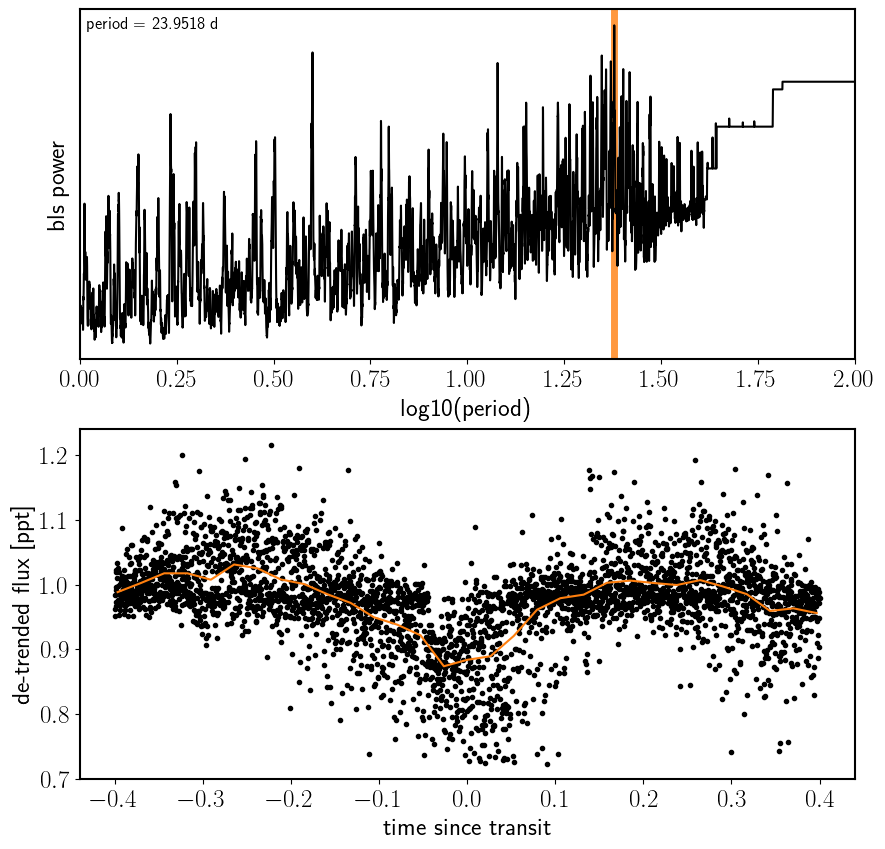

In [46]:
from astropy.timeseries import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(1), np.log(100), 10000))

bls = BoxLeastSquares(clc.time.bkjd,clc.flux.value)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(clc.time.bkjd, bls_period, 0.2, bls_t0)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate(
    "period = {0:.4f} d".format(bls_period),
    (0, 1),
    xycoords="axes fraction",
    xytext=(5, -5),
    textcoords="offset points",
    va="top",
    ha="left",
    fontsize=12,
)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold = (clc.time.bkjd - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
m = np.abs(x_fold) < 0.4
ax.plot(x_fold[m], clc.flux.value[m], ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=clc.flux.value)
denom[num == 0] = 1.0
ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

#ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux [ppt]")
_ = ax.set_xlabel("time since transit")

In [99]:
print(bls_period)

23.951787711408393


### Using lightkurve BLS

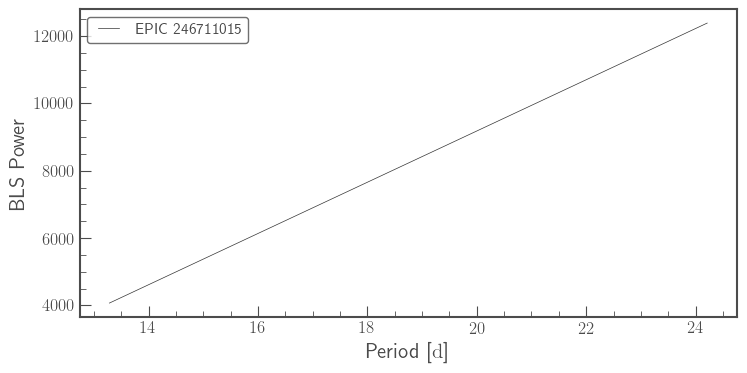

In [107]:
# Create array of periods to search
period2 = [13.284219 , 24.213117]
# Create a BLSPeriodogram
bls2 = clc.to_periodogram(method='bls', period=period2, frequency_factor=500);
bls2.plot();

In [ ]:
planet_period2 = bls2.period_at_max_power
planet_t02 = bls2.transit_time_at_max_power
planet_dur2 = bls2.duration_at_max_power

# Check the value for period
planet_period2

In [105]:
# Create a BLS model using the BLS parameters
planet_model2 = bls2.get_transit_model(period=planet_period2,
                                       transit_time=planet_t02,
                                       duration=planet_dur2)

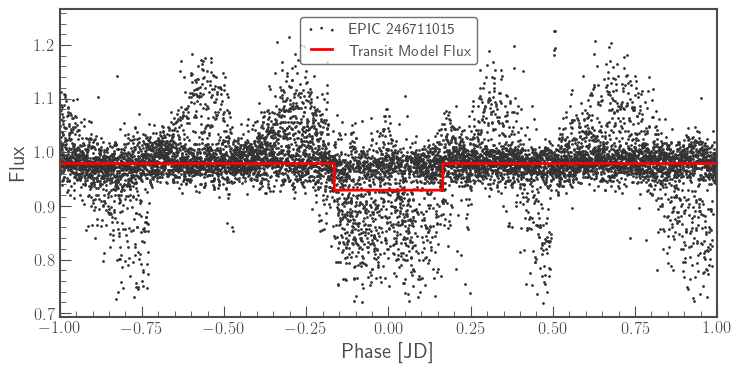

In [103]:
ax = clc.fold(planet_period2, planet_t02).scatter()
planet_model2.fold(planet_period2, planet_t02).plot(ax=ax, c='r', lw=2)
ax.set_xlim(-1, 1);

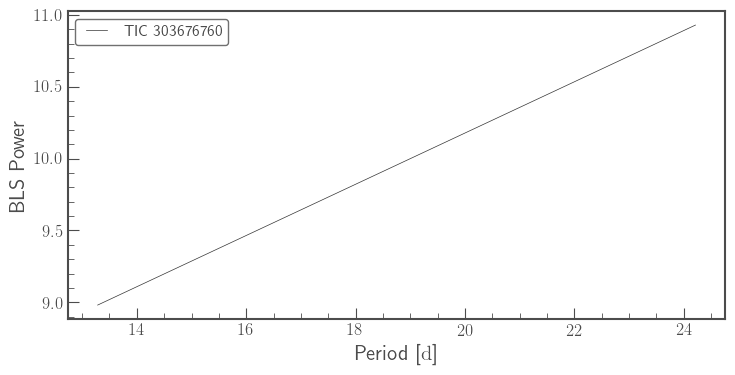

In [108]:
period_dos = [13.284219 , 24.213117]
bls_dos = masked_lc.to_periodogram('bls', period=period_dos, frequency_factor=500)
bls_dos.plot();

In [109]:
planet_c_periodk = bls_dos.period_at_max_power
planet_c_t0k = bls_dos.transit_time_at_max_power
planet_c_durk = bls_dos.duration_at_max_power

# Check the value for period
planet_c_periodk

<Quantity 24.213117 d>

# TESS Data

In [57]:
tstar = lk.search_lightcurve('EPIC 246711015',author='SPOC')
tstar

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 05,2018,SPOC,120,303676760,0.0
1,TESS Sector 32,2020,SPOC,120,303676760,0.0


In [58]:
tess_lc = tstar.download_all()
#lc

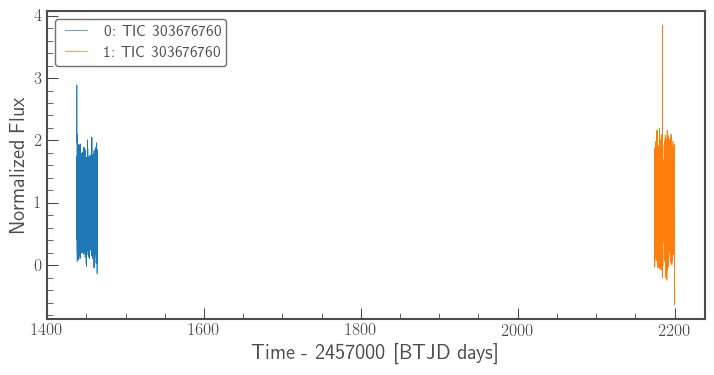

In [59]:
tess_lc.plot(normalize=True);

Text(0.5, 1.0, 'Sector 32')

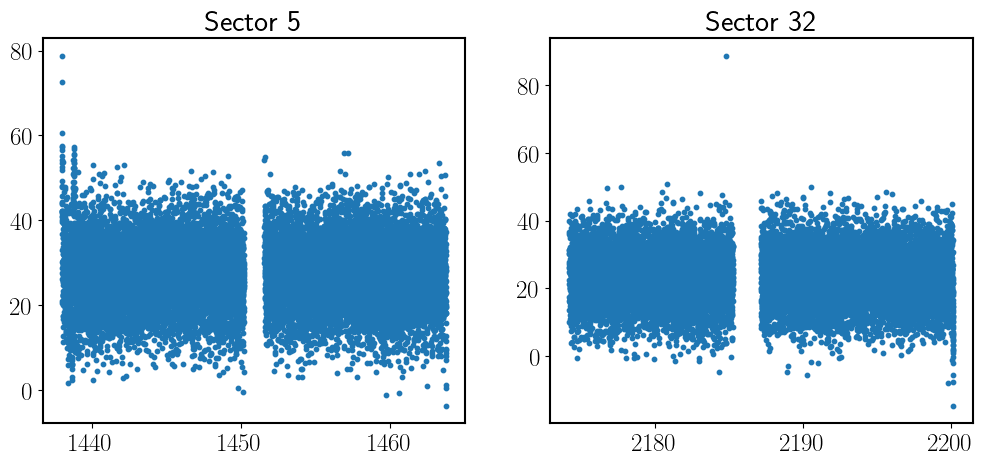

In [60]:
fig,axs = plt.subplots(1,2, figsize=(12,5), facecolor='w', edgecolor='k')
axs[0].scatter(tess_lc[0].time.btjd,tess_lc[0].flux,s=10)
axs[0].set_title('Sector 5')

axs[1].scatter(tess_lc[1].time.btjd,tess_lc[1].flux,s=10)
axs[1].set_title('Sector 32')


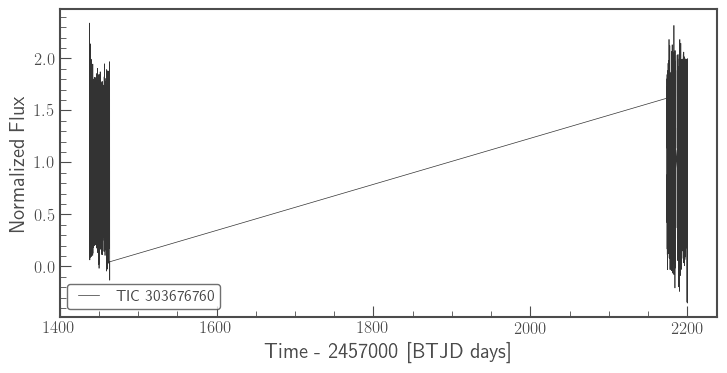

In [61]:
# Flatten the light curve
tess_lc_flat = tess_lc.stitch().flatten(window_length=901).remove_outliers()
tess_lc_flat.plot();

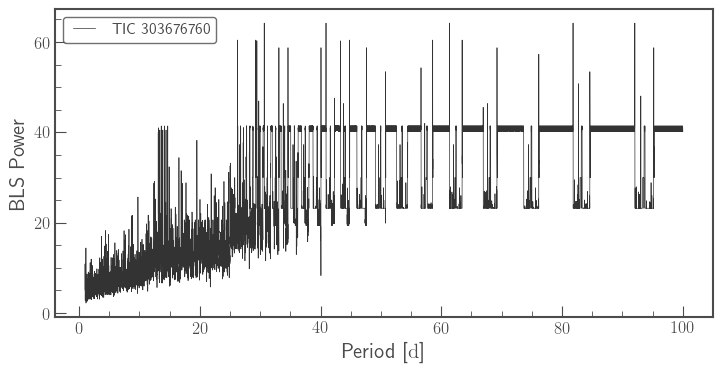

In [62]:
# Create array of periods to search
periodt = np.linspace(1, 100, 10000)
# Create a BLSPeriodogram
blst = tess_lc_flat.to_periodogram(method='bls', period=periodt, frequency_factor=500);
blst.plot();

In [37]:
#noise = np.random.normal(500, 100, 500)
#plt.plot(noise)

In [38]:
#plt.plot(bls.period,bls.power)
#plt.plot(noise)

In [63]:
blst.period_at_max_power.value


30.68316831683168

In [64]:
planet_periodt = blst.period_at_max_power
planet_t0t = blst.transit_time_at_max_power
planet_durt = blst.duration_at_max_power

# Check the value for period
planet_periodt

<Quantity 30.68316832 d>

In [65]:
planet_t0t.value

1463.743414302394

In [66]:
planet_periodt.value

30.68316831683168

In [67]:
blst.depth_at_max_power

<Quantity 0.68330515>

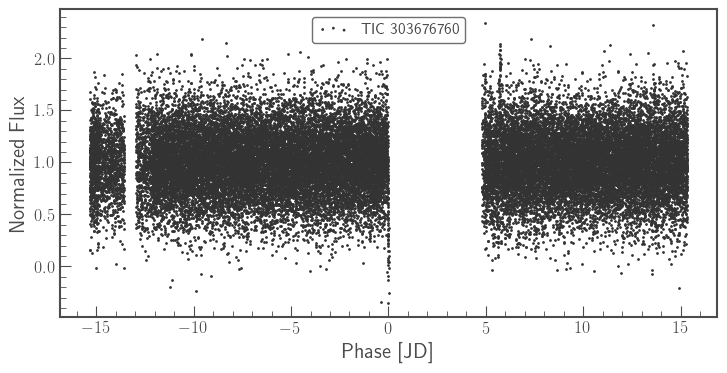

In [68]:
ax = tess_lc_flat.fold(period=planet_periodt, epoch_time=planet_t0t).scatter()
#ax.set_xlim(-1, 1);

In [69]:
# Create a cadence mask using the BLS parameters
planet_mask = blst.get_transit_mask(period=planet_periodt,
                                     transit_time=planet_t0t,
                                     duration=planet_durt)

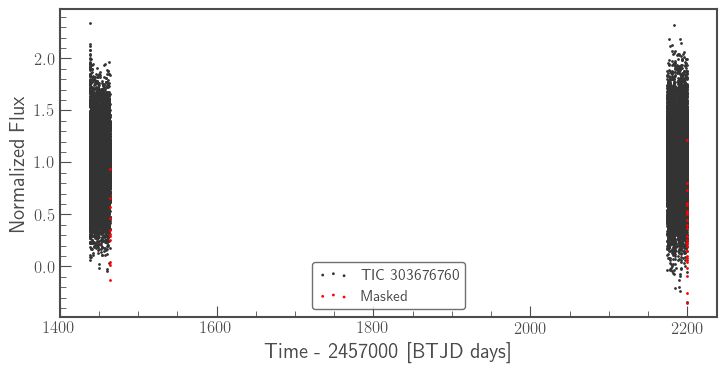

In [70]:
masked_lc = tess_lc_flat[~planet_mask]
ax = masked_lc.scatter();
tess_lc_flat[planet_mask].scatter(ax=ax, c='r', label='Masked');
#ax.set_xlim(2200,2201);

In [71]:
# Create a BLS model using the BLS parameters
planet_model = blst.get_transit_model(period=planet_periodt,
                                       transit_time=planet_t0t,
                                       duration=planet_durt)

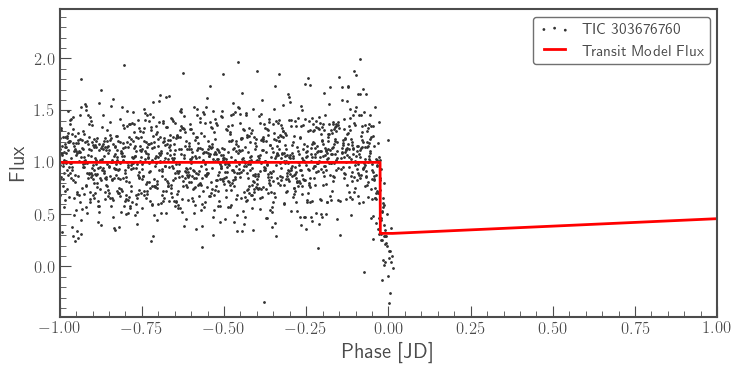

In [72]:
ax = tess_lc_flat.fold(planet_periodt, planet_t0t).scatter()
planet_model.fold(planet_periodt, planet_t0t).plot(ax=ax, c='r', lw=2)
ax.set_xlim(-1, 1);

In [51]:
#lc_flat.interact_bls()

Extra planet signals?

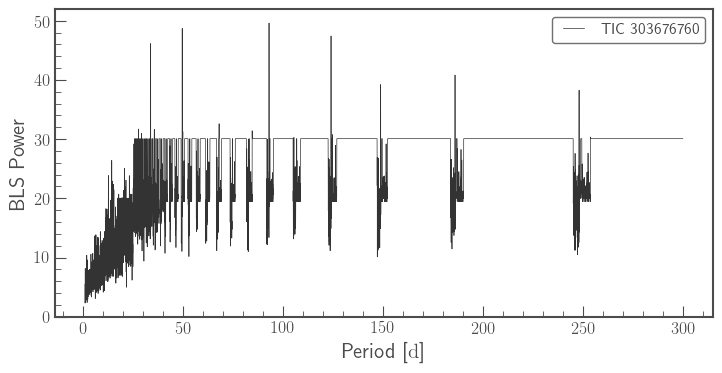

In [73]:
tess_period2 = np.linspace(1, 300, 10000)
tess_bls2 = masked_lc.to_periodogram('bls', period=tess_period2, frequency_factor=500)
tess_bls2.plot();

In [74]:
planet_c_period = tess_bls2.period_at_max_power
planet_c_t0 = tess_bls2.transit_time_at_max_power
planet_c_dur = tess_bls2.duration_at_max_power

# Check the value for period
planet_c_period

<Quantity 93.04140414 d>

<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

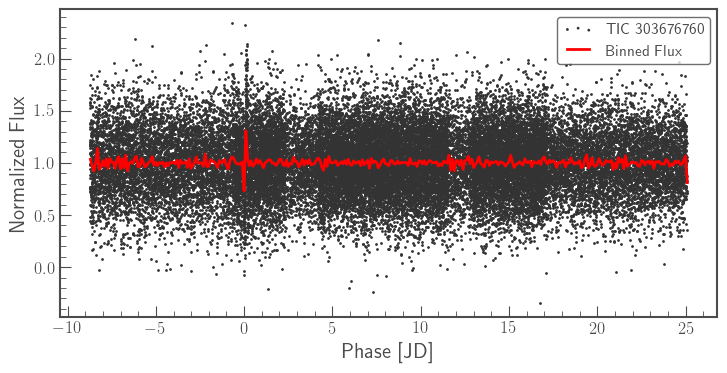

In [76]:
ax = masked_lc.fold(planet_c_period, planet_c_t0).scatter()
masked_lc.fold(planet_c_period, planet_c_t0).bin(.1).plot(ax=ax, c='r', lw=2,
                                                          label='Binned Flux')
#ax.set_xlim(-5, 5);

In [77]:
planet_c_model = bls2.get_transit_model(period=planet_c_period,
                                       transit_time=planet_c_t0,
                                       duration=planet_c_dur)

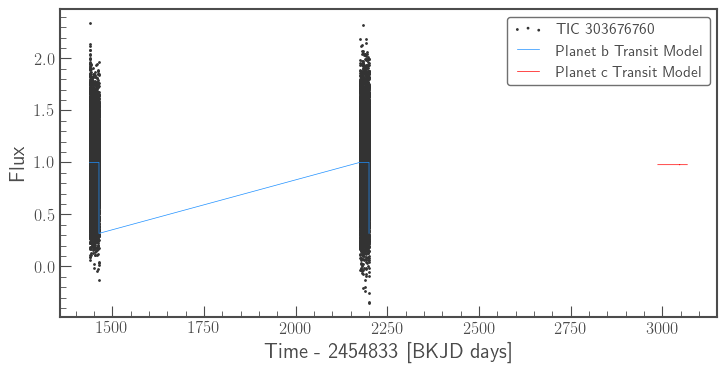

In [78]:
ax = tess_lc_flat.scatter();
planet_model.plot(ax=ax, c='dodgerblue', label='Planet b Transit Model');
planet_c_model.plot(ax=ax, c='r', label='Planet c Transit Model');

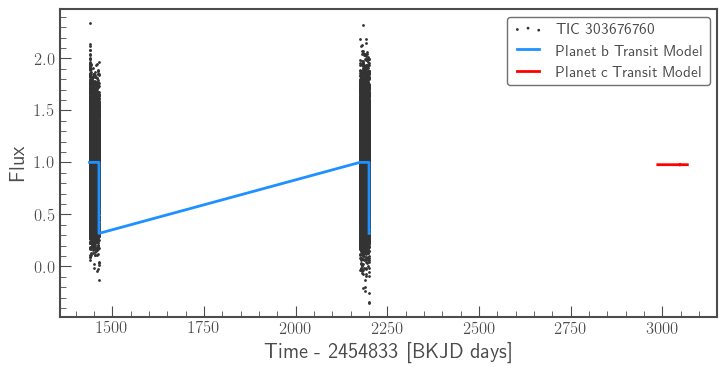

In [79]:
ax = tess_lc_flat.scatter();
planet_model.plot(ax=ax, c='dodgerblue', label='Planet b Transit Model',lw=2);
planet_c_model.plot(ax=ax, c='r', label='Planet c Transit Model',lw=2);
#ax.set_xlim(1410,1415)

#ax.set_xlim(1435,1440)

(1463.0, 1495.0)

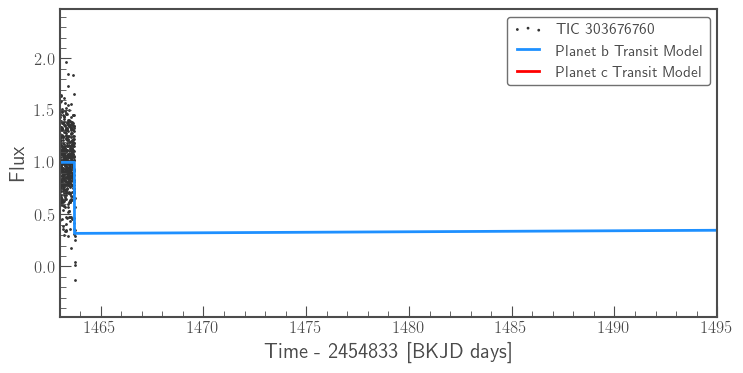

In [80]:
ax = tess_lc_flat.scatter();
planet_model.plot(ax=ax, c='dodgerblue', label='Planet b Transit Model',lw=2);
planet_c_model.plot(ax=ax, c='r', label='Planet c Transit Model',lw=2);
#ax.set_xlim(1410,1415)

ax.set_xlim(1463,1495)

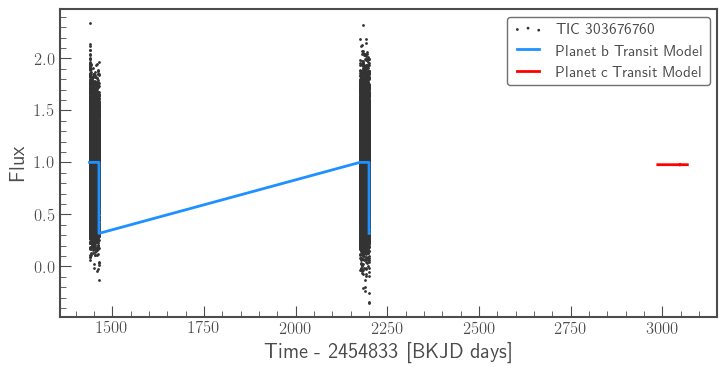

In [82]:
ax = tess_lc_flat.scatter();
planet_model.plot(ax=ax, c='dodgerblue', label='Planet b Transit Model',lw=2);
planet_c_model.plot(ax=ax, c='r', label='Planet c Transit Model',lw=2);
#ax.set_xlim(1438,1440)

#ax.set_xlim(1435,1440)

(2180.0, 2185.0)

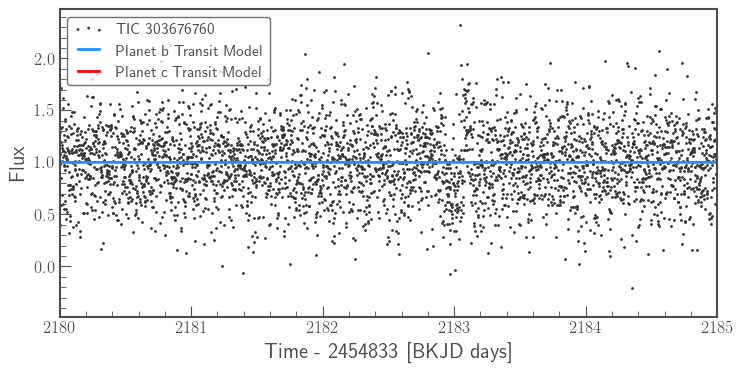

In [83]:
ax = tess_lc_flat.scatter();
planet_model.plot(ax=ax, c='dodgerblue', label='Planet b Transit Model',lw=2);
planet_c_model.plot(ax=ax, c='r', label='Planet c Transit Model',lw=2);
ax.set_xlim(2180,2185)

#ax.set_xlim(1435,1440)

Fitting a transit model using the exoplanet/PyMC3 framework: https://gallery.exoplanet.codes/tutorials/transit/#the-transit-model-in-pymc3

In [ ]:
#import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx

In [ ]:
from celerite2.theano import terms, GaussianProcess
import exoplanet as xo
import pymc3 as pm
import aesara_theano_fallback.tensor as tt

import pymc3_ext as pmx
from celerite2.theano import terms, GaussianProcess

In [ ]:
print(planet_period,planet_c_period)

In [ ]:
np.log(bls.depth_at_max_power)

In [ ]:
periods = [67.91899189918992 , 181.25522552255225]
t0s = periods * np.random.rand(2)
t = lc_flat.time.btjd
y=lc_flat.flux.value
yerr = lc_flat.flux_err.value

In [ ]:
t0s

In [ ]:
bls_depth = bls.depth_at_max_power
bls_depth

In [ ]:
phase_lc = np.linspace(-1, 1, 100)

In [ ]:
def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(t), dtype=bool)
        
    with pm.Model() as model:
        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)

        # Stellar parameters from TFOP
        M_star = 0.286,0.020
        R_star = 0.308,0.009
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal(
            "m_star", mu=M_star[0], sd=M_star[1]
        )
        r_star = BoundedNormal(
            "r_star", mu=R_star[0], sd=R_star[1]
        )

        # Orbital parameters for the planets
        t0 = pm.Normal("t0", mu=planet_t0.value, sd=1)
        log_period = pm.Normal("log_period", mu=np.log(planet_period.value), sd=1)
        period = pm.Deterministic("period", pm.math.exp(log_period))

        # Fit in terms of transit depth (assuming b<1)
        b = pm.Uniform("b", lower=0, upper=2)
        log_depth = pm.Normal("log_depth", mu=np.log(bls_depth), sigma=2.0)
        ror = pm.Deterministic(
            "ror",
            star.get_ror_from_approx_transit_depth(
                1e-3 * pm.math.exp(log_depth), b
            ),
        )
        r_pl = pm.Deterministic("r_pl", ror * r_star)
        
        ecs = pmx.UnitDisk("ecs", testval=np.array([0.01, 0.0]))
        ecc = pm.Deterministic("ecc", pm.math.sum(ecs**2))
        omega = pm.Deterministic("omega", pm.math.arctan2(ecs[1], ecs[0]))
        xo.eccentricity.kipping13("ecc_prior", fixed=True, observed=ecc)

        # Transit jitter & GP parameters
        log_sigma_lc = pm.Normal(
            "log_sigma_lc", mu=np.log(np.std(y[mask])), sd=10
        )
        log_rho_gp = pm.Normal("log_rho_gp", mu=0, sd=10)
        log_sigma_gp = pm.Normal(
            "log_sigma_gp", mu=np.log(np.std(y[mask])), sd=10
        )

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            ecc=ecc,
            omega=omega,
        )

        # Compute the model light curve
        light_curves = (
            star.get_light_curve(orbit=orbit, r=r_pl, t=t[mask], texp=texp)
            * 1e3
        )
        light_curve = pm.math.sum(light_curves, axis=-1) + mean
        resid = y[mask] - light_curve

        # GP model for the light curve
        kernel = terms.SHOTerm(
            sigma=pm.math.exp(log_sigma_gp),
            rho=pm.math.exp(log_rho_gp),
            Q=1 / np.sqrt(2),
        )
        gp = GaussianProcess(kernel, t=t[mask], yerr=pm.math.exp(log_sigma_lc))
        gp.marginal("gp", observed=resid)
        #         pm.Deterministic("gp_pred", gp.predict(resid))

        # Compute and save the phased light curve models
        pm.Deterministic(
            "lc_pred",
            1e3
            * star.get_light_curve(
                orbit=orbit, r=r_pl, t=t0 + phase_lc, texp=texp
            )[..., 0],
        )

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = pmx.optimize(
            start=start, vars=[log_sigma_lc, log_sigma_gp, log_rho_gp]
        )
        map_soln = pmx.optimize(start=map_soln, vars=[log_depth])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[log_period, t0])
        map_soln = pmx.optimize(start=map_soln, vars=[u_star])
        map_soln = pmx.optimize(start=map_soln, vars=[log_depth])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[ecs])
        map_soln = pmx.optimize(start=map_soln, vars=[mean])
        map_soln = pmx.optimize(
            start=map_soln, vars=[log_sigma_lc, log_sigma_gp, log_rho_gp]
        )
        map_soln = pmx.optimize(start=map_soln)

        extras = dict(
            zip(
                ["light_curves", "gp_pred"],
                pmx.eval_in_model([light_curves, gp.predict(resid)], map_soln),
            )
        )

    return model, map_soln, extras
model0, map_soln0, extras0 = build_model()

In [ ]:
plt.plot(t, lc_flat.flux, ".k", ms=4, label="data")
for i, l in enumerate("bc"):
    plt.plot(
        t, map_soln["light_curves"][:, i], lw=1, label="planet {0}".format(l)
    )
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
_ = plt.title("map model")